In [ ]:
!pip install -U mipkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 385, in run
    conflicts = self._determine_conflicts(to_install)
 

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import cv2 as cv
import argparse
from torchvision import models, transforms

import mipkit

In [ ]:
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torchvision
import requests
from io import BytesIO


# from https://github.com/lukemelas/EfficientNet-PyTorch
def round_filters(filters, global_params):
    """Round number of filters based on depth multiplier."""
    multiplier = global_params.width_coefficient
    divisor = global_params.depth_divisor
    min_depth = global_params.min_depth
    if not multiplier:
        return filters

    filters *= multiplier
    min_depth = min_depth or divisor
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_filters < 0.9 * filters:
        new_filters += divisor
    return int(new_filters)

def get_instance_segmentation_model(num_classes, model_name="maskrcnn_resnet50_fpn"):
    # load a pre-trained model for classification
    # and return only the features
    if model_name.startswith("efficientnet"):
        backbone = EfficientNet.from_pretrained(
            model_name, num_classes=num_classes, include_top=False
        )
        # number of output channels
        backbone.out_channels = int(round_filters(1280, backbone._global_params))
        model = MaskRCNN(backbone, num_classes)
    else:
        # load an instance segmentation model pre-trained on COCO

        # Resnet50
        model = torchvision.models.detection.__dict__[model_name](pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    if model_name.startswith("mask") or model_name.startswith("efficientnet"):
        # now get the number of input features for the mask classifier
        in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        # and replace the mask predictor with a new one
        model.roi_heads.mask_predictor = MaskRCNNPredictor(
            in_features_mask, hidden_layer, num_classes
        )
    return model

In [ ]:
# https://drive.google.com/drive/u/0/folders/1TgoczMbgYgqMcr0ZjKJVkTBAeZ76WNXT
!pip install gdown --quiet
# !gdown --id 1m-j_weoxZ5rZjlKGShTGG0PiFgZ0pi0H # checkpoint5
!gdown --id 1JYqyFi5jr2TDK92YfCzCWI48QIQawMOw # checkpoint4 - with augmentation
# https://drive.google.com/file/d/1JYqyFi5jr2TDK92YfCzCWI48QIQawMOw/view?usp=sharing

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1JYqyFi5jr2TDK92YfCzCWI48QIQawMOw
To: /content/checkpoint0004.pth
100% 351M/351M [00:01<00:00, 281MB/s]


In [ ]:
# load the model
# model = models.resnet50(pretrained=True)
# PATH = '/content/checkpoint0005.pth'
PATH = '/content/checkpoint0004.pth'
NUM_CLASSES = 2
THRESHOLD = 0.6

# Load model and weights
model = get_instance_segmentation_model(NUM_CLASSES)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
import torch.nn as nn
from collections import OrderedDict
import warnings

from collections import OrderedDict
# import pytorch_lightning as pl
import torch
import numpy as np
import random


def convert_pymodule_to_flatten_dict(model):
    all_layers = OrderedDict()

    def collect_layers(module, all_layers, previous_layer_name=''):
        layers = getattr(module, 'named_children', dict())
        if not isinstance(layers, dict):
            layers = dict(list(layers()))

            if len(layers) > 0:

                if previous_layer_name != '':
                    all_layers[previous_layer_name] = module

                layers_ = layers.copy()
                for layer_name, layer_module in layers_.items():
                    if previous_layer_name != '':
                        lname = previous_layer_name + '.' + layer_name
                    else:
                        lname = layer_name
                    collect_layers(layer_module, all_layers, lname)
            else:
                all_layers[previous_layer_name] = module

    collect_layers(model, all_layers)
    return all_layers


class PytorchHook(nn.Module):
    def __init__(self, model, output_layers, *args, **kwargs):
        """Forward Hook is to extract outputs from specific layers.

        Args:
            model (torch.Module): 
            output_layers ([type]): [description]
        """
        super().__init__(*args, **kwargs)
        self.output_layers = output_layers
        self.layer_outputs: dict = OrderedDict()
        self.model = model
        self.model_dict = convert_pymodule_to_flatten_dict(model)
        self.hook_handles = []
        self.register_hook()

    def get_layers_output(self):
        return self.layer_outputs

    def get_output_layers(self):
        return self.output_layers

    def register_hook(self, model, layer_name):
        raise NotImplementedError

    def clear_hook(self):
        for handler in self.hook_handles:
            handler.remove()
        self.hook_handles.clear()

    def clear_hook_outputs(self):
        self.layer_outputs.clear()

    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs)

    def _hook_func(self, layer_name):
        def hook(module, input, output):
            self.layer_outputs[layer_name] = output
        return hook


class ForwardHook(PytorchHook):
    def register_hook(self):
        for layer_name in self.output_layers:
            layer_module = self.model_dict.get(layer_name, None)
            if layer_module is None:
                message = 'Not found layer name `{layer_name}`'
                warnings.warn(message)
                continue
            self.hook_handles.append(
                layer_module.register_forward_hook(
                    self._hook_func(layer_name)))





In [ ]:
convert_pymodule_to_flatten_dict(model).keys() 

odict_keys(['transform', 'backbone', 'backbone.body', 'backbone.body.conv1', 'backbone.body.bn1', 'backbone.body.relu', 'backbone.body.maxpool', 'backbone.body.layer1', 'backbone.body.layer1.0', 'backbone.body.layer1.0.conv1', 'backbone.body.layer1.0.bn1', 'backbone.body.layer1.0.conv2', 'backbone.body.layer1.0.bn2', 'backbone.body.layer1.0.conv3', 'backbone.body.layer1.0.bn3', 'backbone.body.layer1.0.relu', 'backbone.body.layer1.0.downsample', 'backbone.body.layer1.0.downsample.0', 'backbone.body.layer1.0.downsample.1', 'backbone.body.layer1.1', 'backbone.body.layer1.1.conv1', 'backbone.body.layer1.1.bn1', 'backbone.body.layer1.1.conv2', 'backbone.body.layer1.1.bn2', 'backbone.body.layer1.1.conv3', 'backbone.body.layer1.1.bn3', 'backbone.body.layer1.1.relu', 'backbone.body.layer1.2', 'backbone.body.layer1.2.conv1', 'backbone.body.layer1.2.bn1', 'backbone.body.layer1.2.conv2', 'backbone.body.layer1.2.bn2', 'backbone.body.layer1.2.conv3', 'backbone.body.layer1.2.bn3', 'backbone.body.lay

In [ ]:
# model

In [ ]:
# model
['backbone.body.layer1.2.relu',
'backbone.body.layer3.5.relu',
'backbone.body.layer4.2.relu']

In [ ]:

model1 = ForwardHook(model, output_layers=['backbone.body.layer1.2.relu',
                                        'backbone.body.layer3.5.relu',
                                        'backbone.body.layer4.2.relu'])

In [ ]:
import requests
from io import BytesIO
from PIL import Image

def load_image_from_url(url):
    print(f'Downloading image from: {url}')
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return img

In [ ]:
# define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# URL = 'https://www.allcountyrecycling.com/blog/admin/uploads/2020/waste-trash-nyc.jpg'
URL = 'https://cdn.theatlantic.com/thumbor/u_oEmOaLcNVG1txpg_5i32F4gu8=/0x181:3500x2150/976x549/media/img/mt/2016/07/RTR4TWG7/original.jpg'
img = load_image_from_url(URL)
img = np.array(img)
# apply the transforms
img = transform(img)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())

torch.Size([3, 512, 512])
torch.Size([1, 3, 512, 512])


In [ ]:
with torch.no_grad():
    y = model1(img)

In [ ]:
# model

Layer Name:  backbone.body.layer1.2.relu
torch.Size([1, 256, 200, 200])


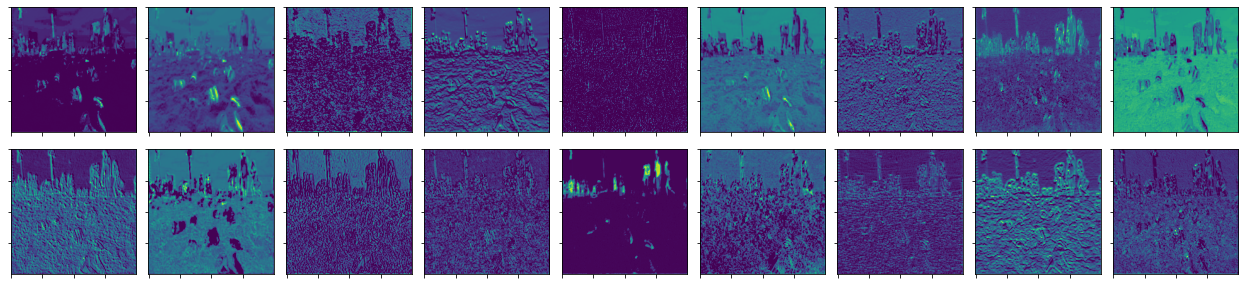

Layer Name:  backbone.body.layer3.5.relu
torch.Size([1, 1024, 50, 50])


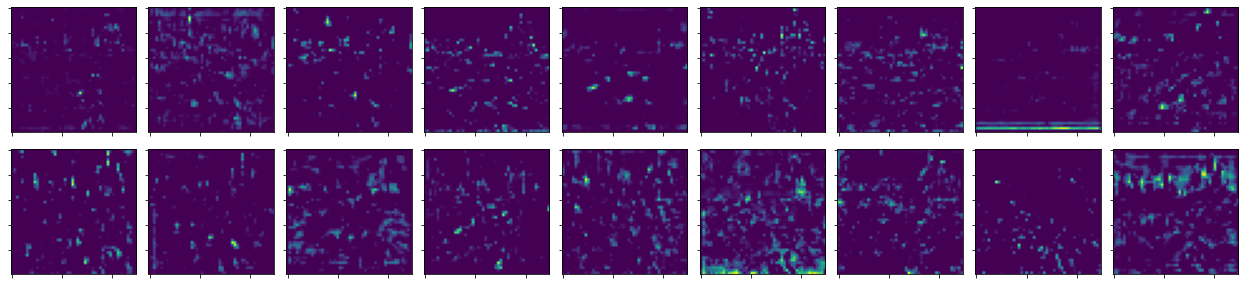

Layer Name:  backbone.body.layer4.2.relu
torch.Size([1, 2048, 25, 25])


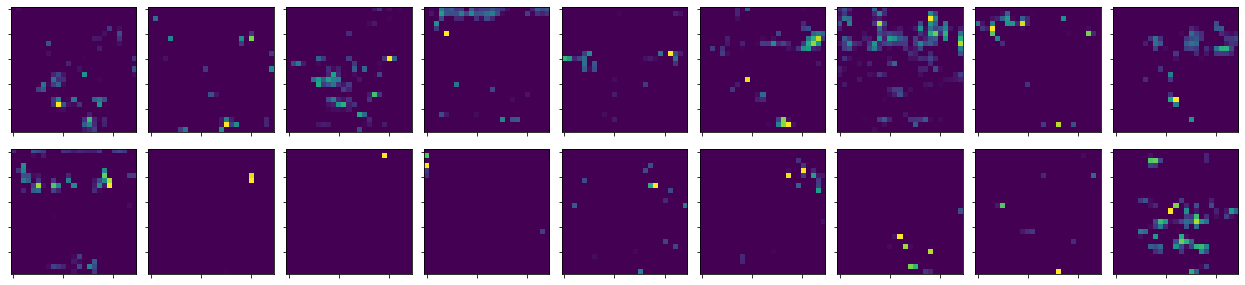

In [ ]:
for layer_name in ['backbone.body.layer1.2.relu', 'backbone.body.layer3.5.relu', 'backbone.body.layer4.2.relu']:
    print('Layer Name: ', layer_name)
    feature_maps = model1.get_layers_output()[layer_name]
    print(feature_maps.shape)
    feature_maps = feature_maps[0]
    mipkit.immulshow(feature_maps[:18], rows=2, ratio_size=5, )
    plt.show()

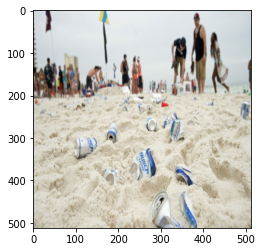

In [ ]:
plt.imshow(img.permute((0, 2, 3, 1))[0])

In [ ]:
# import cv2
# heatmap_img = cv2.applyColorMap(feature_maps[0].numpy(), cv2.COLORMAP_JET)
# super_imposed_img = cv2.addWeighted(heatmap_img, 0.5, img, 0.5, 0)

In [ ]:
parameters_dict = {}
for n, v in model.named_parameters():
    parameters_dict[n] = v.clone().detach().numpy()

In [ ]:
parameters_dict.keys()

dict_keys(['backbone.body.conv1.weight', 'backbone.body.layer1.0.conv1.weight', 'backbone.body.layer1.0.conv2.weight', 'backbone.body.layer1.0.conv3.weight', 'backbone.body.layer1.0.downsample.0.weight', 'backbone.body.layer1.1.conv1.weight', 'backbone.body.layer1.1.conv2.weight', 'backbone.body.layer1.1.conv3.weight', 'backbone.body.layer1.2.conv1.weight', 'backbone.body.layer1.2.conv2.weight', 'backbone.body.layer1.2.conv3.weight', 'backbone.body.layer2.0.conv1.weight', 'backbone.body.layer2.0.conv2.weight', 'backbone.body.layer2.0.conv3.weight', 'backbone.body.layer2.0.downsample.0.weight', 'backbone.body.layer2.1.conv1.weight', 'backbone.body.layer2.1.conv2.weight', 'backbone.body.layer2.1.conv3.weight', 'backbone.body.layer2.2.conv1.weight', 'backbone.body.layer2.2.conv2.weight', 'backbone.body.layer2.2.conv3.weight', 'backbone.body.layer2.3.conv1.weight', 'backbone.body.layer2.3.conv2.weight', 'backbone.body.layer2.3.conv3.weight', 'backbone.body.layer3.0.conv1.weight', 'backbone

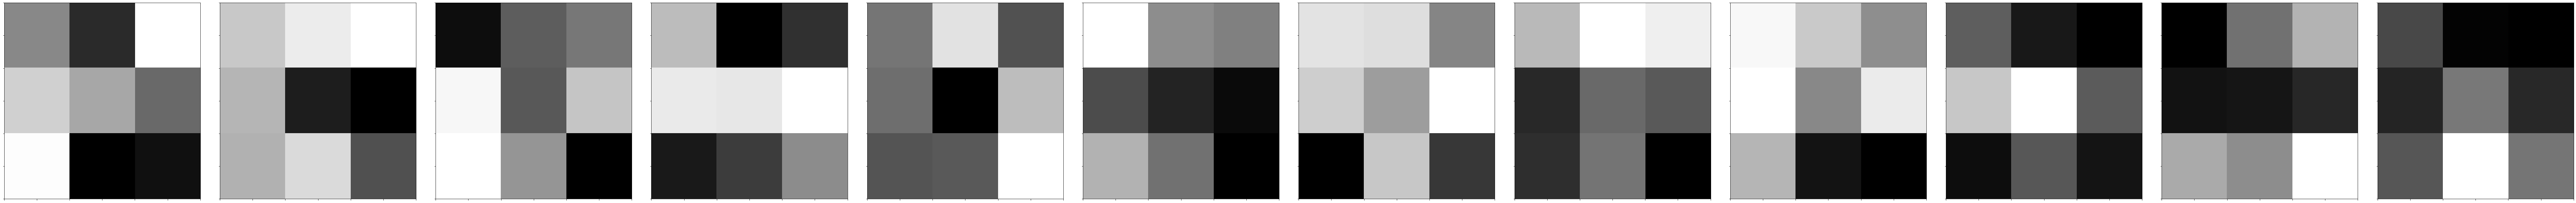

In [ ]:
mipkit.immulshow(parameters_dict['backbone.body.layer1.0.conv2.weight'][0][:12], cmap='gray')

In [ ]:
parameters_dict['backbone.fpn.layer_blocks.3.0.weight'].shape

(256, 256, 3, 3)